In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import mytools

In [3]:
# Specify location of data file
data_loc = '/Users/majdghrear/data/e_dir_fit'

# The data is stored in 100 pickle files each containing 10k electron recoil simulations
files_e = [data_loc+'/processed_training_data/50_keV/processed_recoils_'+str(i)+'.pk' for i in range(1) ]

df = pd.read_pickle(files_e[0])
df.head()

In [14]:
# Method for determining the initial direction of an electron recoil without ML
# refs: https://iopscience.iop.org/article/10.3847/1538-3881/ac51c9/pdf , https://lucidar.me/en/mathematics/weighted-pca/
def non_ML(x_vals, y_vals, z_vals, charges, n_sigma_L = 1.5, n_sigma_H = 3, w_o = 0.05):

    X = np.array([x_vals,y_vals,z_vals]).T

    # 1) Center on barycenter
    x_b = np.sum(X*(charges.reshape(len(charges),1)),axis=0)/np.sum(charges)
    X = X-x_b

    # 2) Find principle axis
    U1,S1,D1 =  np.linalg.svd(X)
    v_PA = np.array([D1[0][0],D1[0][1],D1[0][2]])
    
    # 2)a. Compute second moment about principle axis 
    X_proj = X@v_PA
    M_2 = np.sum( charges * ( X_proj**2 ) ) / np.sum(charges)
    # 2)b. Compute third moment about principle axis 
    M_3 = np.sum( charges * ( X_proj**3 ) ) / np.sum(charges)

    # 3) keep only points where projected sign is same sgn(M3) and n_sigma_L M_2 <|proj_i| < n_sigma_H M2
    X_IR = X [ (np.sign(X_proj) == np.sign(M_3)) & ( (n_sigma_L*M_2) <  np.abs(X_proj) ) & (np.abs(X_proj) < (n_sigma_H*M_2))]
    charges_IR = charges [ (np.sign(X_proj) == np.sign(M_3)) & ( (n_sigma_L*M_2) <  np.abs(X_proj) ) & (np.abs(X_proj) < (n_sigma_H*M_2))]

    # 4) find the interaction point
    x_IP = np.sum(X_IR*(charges_IR.reshape(len(charges_IR),1)),axis=0)/np.sum(charges_IR)

    # 5) Find the final direction
    # Center on interaction point
    X_IR = X_IR-x_IP
    # re-weight charges
    charges_IR = charges_IR * np.exp(-1*np.linalg.norm(X_IR,axis=1)/w_o)
    # Re-shape weights
    W = charges_IR.reshape(len(charges_IR),1)
    # computed weighted covariance matrix
    WCM = ( (W*X_IR).T @ X_IR ) / np.sum(W)
    # run SVD
    U2,S2,D2 = np.linalg.svd(WCM)

    v_IP = np.array([D2[0][0],D2[0][1],D2[0][2]])

    # Assign v_PA the correct head/tail (based on skewness along principal axis)
    v_PA = -1.0*np.sign(M_3)*v_PA
    # Assign v_IP the direction which most agrees with v_PA
    v_IP = np.sign( np.dot(v_IP,v_PA) ) * v_IP

    # Return initial direction prediction
    return v_IP


In [17]:
# Isolate a track
track = df.iloc[2]

x_vals, y_vals, z_vals = track.x, track.y, track.z 
charges =np.ones(len(x_vals))

v_IP = non_ML(x_vals, y_vals, z_vals, charges)

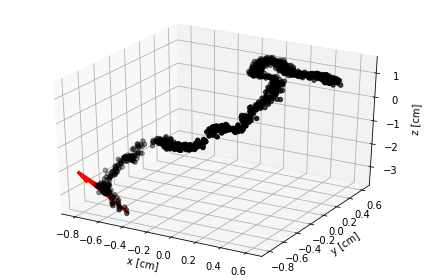

In [22]:
# Plot the track and the true direction
mytools.plot_track_dir(x_vals, y_vals, z_vals, track['offset'], track['dir'])

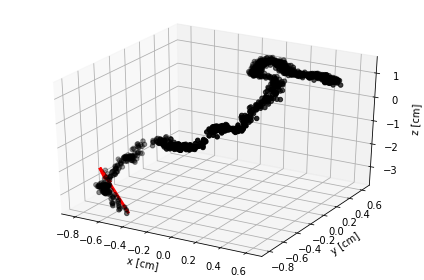

In [23]:
# Plot the track and the measured direction
mytools.plot_track_dir(x_vals, y_vals, z_vals, track['offset'], v_IP)